```
Regression Modeling in Practice Course
by Wesleyan University

Linear Regression Model
Mario Colosso V.
```

In [1]:
%matplotlib inline

import pandas
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pandas.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
pandas.set_option('display.float_format', lambda x:'%.3f'%x)
plt.rcParams['figure.figsize'] = (15, 5)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (15, 5)

#print(plt.style.available)

### Load Forest Fires .csv file

In [3]:
fires = pandas.read_csv('forestfires.csv')

## 1. Lets have a brief look of Fires DataFrame

In [4]:
fires.head()   #Show first rows

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.200,26.200,94.300,5.100,8.200,51,6.700,0.000,0.000
1,7,4,oct,tue,90.600,35.400,669.100,6.700,18.000,33,0.900,0.000,0.000
2,7,4,oct,sat,90.600,43.700,686.900,6.700,14.600,33,1.300,0.000,0.000
3,8,6,mar,fri,91.700,33.300,77.500,9.000,8.300,97,4.000,0.200,0.000
4,8,6,mar,sun,89.300,51.300,102.200,9.600,11.400,99,1.800,0.000,0.000


### Get some descriptive statistic of the data

In [5]:
fires_attributes = fires.columns.values.tolist()
number_of_columns = len(fires_attributes)

In [6]:
statistics = pandas.DataFrame(index=range(0, number_of_columns - 4), columns=('name', 'min', 'max', 'mean'))

In [7]:
for attr in range(4, number_of_columns):
    idx = attr - 4
    statistics.loc[idx] = {'name': fires_attributes[attr], 
                           'min':  min(fires[fires_attributes[attr]]), 
                           'max':  max(fires[fires_attributes[attr]]),
                           'mean': fires[fires_attributes[attr]].mean()}

In [8]:
statistics   #Show min, max and mean 

,name,min,max,mean
0,FFMC,18.700,96.200,90.645
1,DMC,1.100,291.300,110.872
2,DC,7.900,860.600,547.940
3,ISI,0.000,56.100,9.022
4,temp,2.200,33.300,18.889
5,RH,15,100,44.288
6,wind,0.400,9.400,4.018
7,rain,0.000,6.400,0.022
8,area,0.000,1090.840,12.847


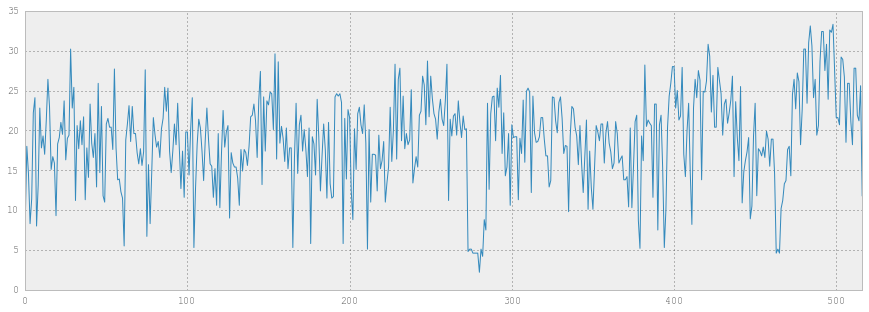

In [9]:
fires['temp'].plot()   #Plot temperature graph

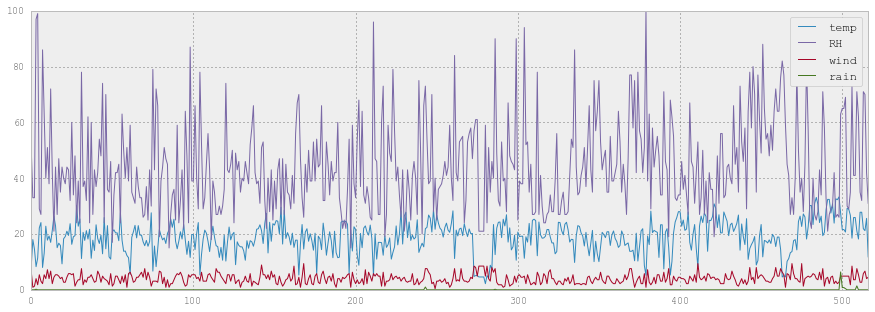

In [10]:
fires[['temp', 'RH', 'wind', 'rain']].plot()   #Plot temperature, relative humidity, wind and rain graphs

In [11]:
print(fires.corr())   #Show correlation between variables

          X      Y   FFMC    DMC     DC    ISI   temp     RH   wind   rain  \
X     1.000  0.540 -0.021 -0.048 -0.086  0.006 -0.051  0.085  0.019  0.065   
Y     0.540  1.000 -0.046  0.008 -0.101 -0.024 -0.024  0.062 -0.020  0.033   
FFMC -0.021 -0.046  1.000  0.383  0.331  0.532  0.432 -0.301 -0.028  0.057   
DMC  -0.048  0.008  0.383  1.000  0.682  0.305  0.470  0.074 -0.105  0.075   
DC   -0.086 -0.101  0.331  0.682  1.000  0.229  0.496 -0.039 -0.203  0.036   
ISI   0.006 -0.024  0.532  0.305  0.229  1.000  0.394 -0.133  0.107  0.068   
temp -0.051 -0.024  0.432  0.470  0.496  0.394  1.000 -0.527 -0.227  0.069   
RH    0.085  0.062 -0.301  0.074 -0.039 -0.133 -0.527  1.000  0.069  0.100   
wind  0.019 -0.020 -0.028 -0.105 -0.203  0.107 -0.227  0.069  1.000  0.061   
rain  0.065  0.033  0.057  0.075  0.036  0.068  0.069  0.100  0.061  1.000   
area  0.063  0.045  0.040  0.073  0.049  0.008  0.098 -0.076  0.012 -0.007   

       area  
X     0.063  
Y     0.045  
FFMC  0.040  
DMC   0

## 2. Linear regression

### Convert categorical variables (months and days) into numerical values

In [12]:
months_table = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
days_table =   ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat']

fires['month'] = [months_table.index(month) for month in fires['month'] ]
fires['day'] =   [days_table.index(day)     for day   in fires['day']   ]

fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,2,5,86.200,26.200,94.300,5.100,8.200,51,6.700,0.000,0.000
1,7,4,9,2,90.600,35.400,669.100,6.700,18.000,33,0.900,0.000,0.000
2,7,4,9,6,90.600,43.700,686.900,6.700,14.600,33,1.300,0.000,0.000
3,8,6,2,5,91.700,33.300,77.500,9.000,8.300,97,4.000,0.200,0.000
4,8,6,2,0,89.300,51.300,102.200,9.600,11.400,99,1.800,0.000,0.000


### Center each explanatory variable

In [13]:
for idx in range(0, number_of_columns - 1):
    fires[fires_attributes[idx]] = fires[fires_attributes[idx]] - fires[fires_attributes[idx]].mean()

In [14]:
for idx in range(0, number_of_columns):
    statistics.loc[idx] = {'name': fires_attributes[idx], 
                           'min':  min(fires[fires_attributes[idx]]), 
                           'max':  max(fires[fires_attributes[idx]]),
                           'mean': fires[fires_attributes[idx]].mean()}

In [15]:
statistics   #Only explanatory variables were centered

,name,min,max,mean
0,X,-3.669,4.331,0.000
1,Y,-2.300,4.700,0.000
2,month,-6.476,4.524,0.000
3,day,-2.973,3.027,-0.000
4,FFMC,-71.945,5.555,0.000
5,DMC,-109.772,180.428,-0.000
6,DC,-540.040,312.660,0.000
7,ISI,-9.022,47.078,-0.000
8,temp,-16.689,14.411,0.000
9,RH,-29.288,55.712,0.000


### Generate models to test each variable

In [16]:
for idx in range(4, number_of_columns - 1):
    model = smf.ols(formula = "area ~ " + fires_attributes[idx], data = fires).fit()
    print(model.summary())
    print()

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8304
Date:                Thu, 02 Jun 2016   Prob (F-statistic):              0.363
Time:                        23:38:35   Log-Likelihood:                -2880.0
No. Observations:                 517   AIC:                             5764.
Df Residuals:                     515   BIC:                             5773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.8473      2.800      4.588      0.0

#### The results of the linear regression models indicated than only temperature (Beta = 1.0726, p = 0.026) was significantly and positively associated with the total burned area due to forest fires. _'p-value'_ of other models are greater than treshold value of 0.05 so results are not statistically significant to reject null hypothesis.

### Create a Linear Regression Model for a combination of variables

In [17]:
explanatory_variables = "FFMC + DMC + DC + ISI + temp + RH + wind + rain"
response_variable =     "area"

model = smf.ols(formula = response_variable + " ~ " + explanatory_variables, data = fires).fit()

In [18]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.033
Date:                Thu, 02 Jun 2016   Prob (F-statistic):              0.410
Time:                        23:38:35   Log-Likelihood:                -2876.3
No. Observations:                 517   AIC:                             5771.
Df Residuals:                     508   BIC:                             5809.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.8473      2.799      4.590      0.0

#### _p-value_ of combination model (p = 0.410) is bigger than treshold value, so the combination of the Canadian Forest Fire Weather Index (FWI) system plus temperature, humidity, wind and rain are not significantly associated with the total burned area due to forest fires. _p-value_ of temperature in combination model (p = 0.282) is not longer statistically significant, a confounder variable?